# **JOB APPLICATION: NEWTRAL (2022-I)**
## Objetivo.
Implementar un detector de clickbait en tweets publicados por medios de comunicación en inglés (por ejemplo: “Donald
Trump wants everything about America to be strong. He just announced one big exception.”).
Para ello dispones de un dataset que puedes usar para entrenar y evaluar un modelo predictivo. La tarea tiene los siguientes requisitos:

## Descarga
El dataset [Webis-Clickbait](https://webis.de/data/webis-clickbait-17.html) en formato CSV de los siguientes enlaces: 
> training https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_train.csv

> test https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_test.csv.

El texto del tweet se encuentra en la columna postText, y su etiqueta en la columna truthClass. 


## Instrucciones
Crea un **notebook** con la solución a las tareas indicadas más abajo. Te recomendamos utilizar Google Colab para disponer de recursos de cómputo gratuitos.

Incluye un **análisis descriptivo** de los datos.
Céntrate en los aspectos que vayan a ser más importantes para el funcionamiento del modelo.

**Crea un modelo de detección de clickbait en tweets**, utilizando la técnica de **fine-tuning de un modelo pre-entrenado de tipo BERT** (es decir, son válidos cualquier checkpoint de BERT o modificaciones como RoBERTa, XLM, etc). Puedes utilizar librerías y checkpoints como Huggingface Transformers, o cualquier otro a tu elección. 

Deberías entregar como **mínimo una solución, y adicionalmente una comparativa** entre varias soluciones modificando el modelo, sus parámetros o incorporando otras ideas, opcionalmente añadiendo baselines más simples no basados en Transformers.


**Evalúa tu solución** en el conjunto de test proporcionado. Elige las métricas que consideres más adecuadas para el problema y añade un párrafo interpretando tus resultados.

**Incluye un pequeño análisis de errores del conjunto de test** que permita entender mejor cómo falla el modelo.

Utiliza **Python>=3.6** y las librerías que desees del ecosistema de machine learning de Python.

Comparte tu notebook a través de un **repositorio de GitHub público** y nvíanos el enlace.


Valoraremos, además de las soluciones presentadas, la calidad del código y de las argumentaciones hechas.

Puedes profundizar todo lo que quieras en la tarea si te parece interesante, pero los requisitos mínimos para su valoración son los que indicamos más arriba.


[BERT original paper](https://arxiv.org/pdf/1810.04805.pdf)

---

# **RESPUESTA DEL APLICANTE**

## Comentario general.

Entrego la solución con un único modelo, aunque hice pruebas con un par más de los presentes en el TF HUB. No los he incluido por falta de tiempo en desarrollar la comparativa.

*La implementación se ha basado parcialmente en [este tutorial de Google Classify text with BERT](https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=en).*

## Recurso BERT

He optado por usar el hub de TensorFlow, en lugar de Transformers; ya había usado este repositorio anteriormente. Puede que sus modelos no estén tan  optimizados (creo que los pesos corresponden a los del entrenamiento del paper original).

## Fine-Tuning

En un prinicip, pensaba que debía hacer un ajuste fino por capas/niveles (como, por ejemplo, en visión por computador). Pero leyendo las recomendaciones del TF Hub, no lo recomiendan así, así que encontrarán un training completo del modelo; eso sí, un número reducido de epochs.


## Selección de modelos

Se explicar durante el recorrido por el notebook, pero lo destaco aquí: los modelos BERET de 128 dimensiones deben de bastar: 128 tokens=palabras, para tuits de 280 caracteres es suficiente. Y más cuando los tuits de la muestra son mucho más cortos (ver apartado de análisis descriptivo).

## Métricas

Me habría gustado usar el coeficiente F1 durante el entrenamiento, que me parece una métrica bastante adecuada en problemas de clasificación binaria, más cuando hay desbalanceo de clases. Me topé con fallos al aplicar la librería tensorflow_addons, así que lo he descartado en esta revisión, dejándolo para una futura iteración del problema. No obstante, se ha obtenido parcialmente a través de la matriz de confusión, sobre el conjunto de test

## Futuras mejoras
¿Posible road-map futuro? entrenar más modelos distintos, usar librería Transformers, entrenar por capas si fuera posible con esta librería, aplicar alguna métrica adicional y un análisis más exhaustivo.

---

# ÍNDICE

1. [Librerías](#libraries)

2. [Feature engineering](#feat_eng)

3. [Selección de modelos y preprocesamiento de texto](#model_selection)

4. [Entrenamiento](#training)

5. [Evaluación](#evaluation)

---

<a name='libraries'></a>
# 1. LIBRERÍAS Y DIRECTORIO DE TRABAJO (GCOLAB)

In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

He seguido la indicación de usar un optimizador dinámico (AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models)).

In [6]:
!pip install -q tf-models-official==2.7.0

In [7]:
import os
from google.colab import drive
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

#import matplotlib.image as mpimg


In [8]:
# comprobamos que está montado y cambiamos al directorio de trabajo concreto
# si estamos en local, no cambiamos directorio
if 'google.colab' in str(get_ipython()):   
    drive.mount('/content/personal_drive')
    os.chdir('/content/personal_drive/My Drive/jobs_application/2022_newtral')
    print('Running on CoLab')
else:
    os.chdir('../')
    print('Not running on CoLab')

Drive already mounted at /content/personal_drive; to attempt to forcibly remount, call drive.mount("/content/personal_drive", force_remount=True).
Running on CoLab


In [9]:
ls -l

total 1032
drwx------ 2 root root   4096 Apr  4 15:01 _aux_notebooks/
drwx------ 2 root root   4096 Apr  4 15:01 data/
-rw------- 1 root root  41102 Apr  5 19:02 model.png
-rw------- 1 root root 344114 Apr  5 05:30 newtral_application_test_rev_02.ipynb
-rw------- 1 root root 346457 Apr  5 06:41 newtral_application_test_rev_03.ipynb
-rw------- 1 root root 299412 Apr  5 19:37 newtral_application_test_rev_04.ipynb
drwx------ 2 root root   4096 Apr  4 15:01 _old/
drwx------ 2 root root   4096 Apr  4 07:05 webis_bert/
drwx------ 2 root root   4096 Apr  5 05:50 webis_bert03/
drwx------ 4 root root   4096 Apr  5 16:41 webis_bert04/


---

<a name='feat_eng'></a>
# 2. FEATURE ENGINEERING

### Importación

In [10]:
# Lets import the data into data frames
df_src_train =  pd.read_csv("data/webis_train.csv")
df_src_test =  pd.read_csv("data/webis_test.csv")

### Exploración de los datos

In [11]:
df_src_all = pd.concat([df_src_train, df_src_test], ignore_index=True)

In [12]:
df_src_all.head()

,Unnamed: 0,postMedia,postText,id,targetCaptions,targetParagraphs,targetTitle,postTimestamp,targetKeywords,targetDescription,truthJudgments,truthMean,truthClass,truthMedian,truthMode
0,0,[],UK’s response to modern slavery leaving victim...,858462320779026432,['modern-slavery-rex.jpg'],['Thousands of modern slavery victims have\xa0...,‘Inexcusable’ failures in UK’s response to mod...,Sat Apr 29 23:25:41 +0000 2017,"modern slavery, Department For Work And Pensio...",“Inexcusable” failures in the UK’s system for ...,"[0.33333333330000003, 0.0, 0.33333333330000003...",0.133333,no-clickbait,0.000000,0.000000
1,1,[],this is good,858421020331560960,"['In this July 1, 2010 file photo, Dr. Charmai...",['President Donald Trump has appointed the\xa0...,Donald Trump Appoints Pro-Life Advocate as Ass...,Sat Apr 29 20:41:34 +0000 2017,"Americans United for Life, Dr. Charmaine Yoest...",President Donald Trump has appointed pro-life ...,"[1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,clickbait,1.000000,1.000000
2,2,[],"The ""forgotten"" Trump roast: Relive his brutal...",858368123753435136,"[""President Trump will not attend this year's ...",['When the\xa0White House correspondents’ dinn...,The ‘forgotten’ Trump roast: Relive his brutal...,Sat Apr 29 17:11:23 +0000 2017,"trump whcd, whcd, white house correspondents d...",President Trump won't be at this year's White ...,"[0.33333333330000003, 1.0, 0.33333333330000003...",0.466667,no-clickbait,0.333333,0.333333
3,3,[],Meet the happiest #dog in the world!,858323428260139008,"['Maru ', 'Maru', 'Maru', 'Maru', 'Maru']",['Adorable is probably an understatement. This...,"Meet The Happiest Dog In The World, Maru The H...",Sat Apr 29 14:13:46 +0000 2017,"Maru, husky, dogs, pandas, furball, instagram","The article is about Maru, a husky dog who has...","[1.0, 0.6666666666000001, 1.0, 1.0, 1.0]",0.933333,clickbait,1.000000,1.000000
4,4,[],Tokyo's subway is shut down amid fears over an...,858283602626347008,"[""All nine lines of Tokyo's subway system were...","[""One of Tokyo's major subways systems says it...",Tokyo's subway is shut down amid fears over an...,Sat Apr 29 11:35:31 +0000 2017,"Tokyo,subway,shut,fears,North,Korean,attack","The temporary suspension, which lasted ten min...","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,no-clickbait,0.000000,0.000000


In [13]:
for i in range(0,5):
    print(df_src_all['postText'][i])

UK’s response to modern slavery leaving victims destitute while abusers go free
this is good
The "forgotten" Trump roast: Relive his brutal 2004 thrashing at the New York Friars Club
Meet the happiest #dog in the world!
Tokyo's subway is shut down amid fears over an imminent North Korean missile attack on Japan


In [14]:
for i in range(0,5):
    print(df_src_all['targetTitle'][i])

‘Inexcusable’ failures in UK’s response to modern slavery leaving victims destitute while abusers go free, report warns
Donald Trump Appoints Pro-Life Advocate as Assistant Secretary of HHS for Public Affairs
The ‘forgotten’ Trump roast: Relive his brutal 2004 thrashing at the New York Friars Club
Meet The Happiest Dog In The World, Maru The Husky Who Also Looks Like A Panda!
Tokyo's subway is shut down amid fears over an imminent North Korean missile attack on Japan


In [15]:
for i in range(0,5):
    print(df_src_all['targetParagraphs'][i])

['Thousands of modern slavery victims have\xa0not come forward, while others who have chosen to report their enslavers have ended up destitute as a result of insufficient support, say\xa0MPs', '“Inexcusable” failures in the UK’s system for dealing with modern slavery are\xa0leaving victims reduced to destitution while their abusers go free because they are not adequately supported to testify against them, an alarming report has warned.', 'Thousands of\xa0victims\xa0have not come forward, while others who have chosen to give evidence against their enslavers have ended up destitute as a result of insufficient support, according to\xa0a report published\xa0today by\xa0the Work and Pensions Committee.', 'It is estimated there are between 10,000 and 13,000 victims of modern slavery in the UK, but the report\xa0warns that failings in the current mechanism mean\xa0that once they are identified, they have no automatic formal immigration status or rights.', 'Weak and uncoordinated frontline sup

In [16]:
for i in range(0,5):
    print(df_src_all['targetDescription'][i])

“Inexcusable” failures in the UK’s system for dealing with modern slavery are leaving victims reduced to destitution while their abusers go free because they are not adequately supported to testify against them, an alarming report has warned.
President Donald Trump has appointed pro-life advocate and former president of Americans United for Life Dr. Charmaine Yoest to be Assistant Secretary of Public Affairs for the Department of Health and Human Services.
President Trump won't be at this year's White House correspondents' dinner, but he once endured a tough roast in one of the most New York of rituals.
The article is about Maru, a husky dog who has an uncanny resemblance to a panda.
The temporary suspension, which lasted ten minutes, affected 13,000 people. Service was halted on all nine lines at 6:07 am and was resumed at 6:17 am after there was no threat.


In [17]:
for i in range(0,5):
    print(df_src_all['truthJudgments'][i])

[0.33333333330000003, 0.0, 0.33333333330000003, 0.0, 0.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[0.33333333330000003, 1.0, 0.33333333330000003, 0.0, 0.6666666666000001]
[1.0, 0.6666666666000001, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0]


### Análisis descriptivo

In [18]:
df_src_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38517 entries, 0 to 38516
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         38517 non-null  int64  
 1   postMedia          38517 non-null  object 
 2   postText           38397 non-null  object 
 3   id                 38517 non-null  int64  
 4   targetCaptions     38517 non-null  object 
 5   targetParagraphs   38517 non-null  object 
 6   targetTitle        38517 non-null  object 
 7   postTimestamp      38517 non-null  object 
 8   targetKeywords     24234 non-null  object 
 9   targetDescription  36650 non-null  object 
 10  truthJudgments     38517 non-null  object 
 11  truthMean          38517 non-null  float64
 12  truthClass         38517 non-null  object 
 13  truthMedian        38517 non-null  float64
 14  truthMode          38517 non-null  float64
dtypes: float64(3), int64(2), object(10)
memory usage: 4.4+ MB


Veamos el resumen de las variables numéricas

In [19]:
df_src_all.describe()

,Unnamed: 0,id,truthMean,truthMedian,truthMode
count,38517.000000,3.851700e+04,38517.000000,38517.000000,38517.000000
mean,9630.778202,8.314205e+17,0.308799,0.269812,0.263044
std,5563.033758,1.570486e+16,0.262504,0.336165,0.360209
min,0.000000,8.041138e+17,0.000000,0.000000,0.000000
25%,4814.000000,8.178225e+17,0.066667,0.000000,0.000000
50%,9629.000000,8.315186e+17,0.266667,0.000000,0.000000
75%,14443.000000,8.450344e+17,0.466667,0.333333,0.333333
max,19537.000000,8.584652e+17,1.000000,1.000000,1.000000


Seguramente, algunas de estas variables (las truthXXXX) serían interesantes de cara a un clasificacdor distinto, o combinado. Pero nos vamos a centrar en la única variable predictora que usaremos: `postText`.

**Importante**: la clase objetivo, dos valores (SÍ/NO). ¿Hay desbalanceo acuciado? 

In [20]:
df_src_all['truthClass'].value_counts()

no-clickbait    29241
clickbait        9276
Name: truthClass, dtype: int64

In [21]:
df_src_train['truthClass'].value_counts()

no-clickbait    14777
clickbait        4761
Name: truthClass, dtype: int64

In [22]:
df_src_test['truthClass'].value_counts()

no-clickbait    14464
clickbait        4515
Name: truthClass, dtype: int64

A simple vista, los datasets *train* y *test* presentan una proporción de clases similar.

Además, el tamaño de ambos datasets es prácticamente idéntico. Este hecho marca diferencia en cuanto a la típica distribución de splits de datasets (ejemplo: 80-10-10). No obstante, mantendremos la partición ya que no se nos indicó lo contrario. También resultará conveniente a fin de comparar en un futuro con los actuales estándares del [TIRA ClickBait Challenge](https://www.tira.io/task/clickbait-detection/dataset/clickbait17-test-170720/).

In [23]:
print('Porcentaje de clase NO-CLICKBAIT: {:.2f}%'.format(np.ma.count(np.where(df_src_all['truthClass'] == 'no-clickbait')) * 100 / df_src_all['truthClass'].count()))
print('Porcentaje de clase CLICKBAIT: {:.2f}%'.format(np.ma.count(np.where(df_src_all['truthClass'] == 'clickbait')) * 100 / df_src_all['truthClass'].count()))

Porcentaje de clase NO-CLICKBAIT: 75.92%
Porcentaje de clase CLICKBAIT: 24.08%


Text(0.5, 1.0, 'Distribución de las clases objetivo')

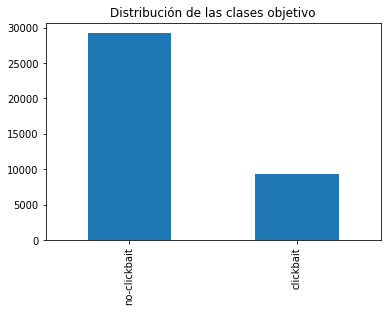

In [24]:
df_src_all['truthClass'].value_counts().plot.bar()
plt.title('Distribución de las clases objetivo')

Ratio 3-1 en las clases objetivos.

Comprobamos los valores nulos

In [25]:
df_src_all.isnull().sum()

Unnamed: 0               0
postMedia                0
postText               120
id                       0
targetCaptions           0
targetParagraphs         0
targetTitle              0
postTimestamp            0
targetKeywords       14283
targetDescription     1867
truthJudgments           0
truthMean                0
truthClass               0
truthMedian              0
truthMode                0
dtype: int64

Observamos valores nulos en los tuits. ¿Son tuits sin texto? Parece que sí, pues suelen incluir información completa sobre las noticias. 

Veamos un resumen del campo `postText`, que nos ayudará, entre otras cosas, a guiar la elección de modelos BERT concretos.

In [26]:
# para poder mostrar las estadísticas resumen, debemos lidiar con los nan's
df_src_all['postText'] = df_src_all['postText'].fillna('')

# resumen de los tuits
print('Media de palabras por tuit: {0:.0f}.'.format(np.mean(df_src_all['postText'].apply(lambda x: len(x.split())))))
print('Máxima longitud de una palabra dentro de un tuit: {0:.0f}.'.format(np.max(df_src_all['postText'].apply(lambda x: len(x.split())))))
print('Media de longitud de caracteres por tuit: {0:.0f}.'.format(np.mean(df_src_all['postText'].apply(lambda x: len(x)))))

Media de palabras por tuit: 12.
Máxima longitud de una palabra dentro de un tuit: 26.
Media de longitud de caracteres por tuit: 71.


## Preparación de los datos

Función de **preprocesado básico**:
> Eliminar tuits en blanco (nan): descartamos (unilateralmente) tuits en blanco. Cuestionable, pero se escoge así. 

> nueva columna "y": numérica (transformación binaria de la clase objetivo)

> renombrar columnas

> reducir dataset a los predictores (1) y la respuesta para continuar el pipeline

In [27]:
def preprocess_basic(df):
    df['postText'] = df['postText'].fillna('')
    #df = df[df['postText'].notna()]
    df = df.drop(df[df['postText'] == ''].index)
    df['y'] = df['truthClass'].apply(lambda x: 1 if x=='clickbait' else 0)
    df = df.rename(columns={"postText": "X"})
    return df[['X', 'y']]

In [28]:
df_train = preprocess_basic(df_src_train)
df_test = preprocess_basic(df_src_test)

Partición del conjunto de entrenamiento en dos: entrenamiento y validación

In [29]:
from sklearn.model_selection import train_test_split
# Since the dataset is very imbalanced we will keep the same distribution in both train and test set by stratifying it based on the labels
# using small portions of the data as the over all dataset would take ages to train, feel free to include more data by changing train_size 
df_train, df_valid = train_test_split(df_train, random_state=42, train_size=0.9, stratify=df_train['y'])
print(df_train.shape)
print(df_valid.shape)

(17535, 2)
(1949, 2)


Convertimos los 3 subconjuntos a TensorFlow

In [30]:
tf_train = tf.data.Dataset.from_tensor_slices((df_train['X'], df_train['y']))
tf_valid = tf.data.Dataset.from_tensor_slices((df_valid['X'], df_valid['y']))
tf_test = tf.data.Dataset.from_tensor_slices((df_test['X'], df_test['y']))

Definimos el flujo de datos de cada subcojunto: aleatoriedad, repetición del dataset y tamaño de los lotes.

In [31]:
BATCH_SIZE = 32
NR_EPOCHS = 1

def create_dataset(dataset, epochs=1, batch_size=32, buffer_size=10000, train=True):
    if train:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    if train:
        dataset = dataset.prefetch(1)
    
    return dataset

train_dataset = create_dataset(tf_train, epochs=NR_EPOCHS, batch_size=BATCH_SIZE)
valid_dataset = create_dataset(tf_valid, epochs=NR_EPOCHS, batch_size=BATCH_SIZE)
test_dataset = create_dataset(tf_test, epochs=NR_EPOCHS, batch_size=BATCH_SIZE, train=False)

---

<a name='model_selection'></a>
# 3. SELECCIÓN DEL MODELO Y PREPROCESAMIENTO DE TEXTOS

Para la selección de modelos, dada la longitud de los tuits, nos centraremos en el uso de modelos de 128, suficientes para la cantidad de palabras (tokens) que recibirá.

## Modelo escogido (#1)

In [32]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-12_H-128_A-2'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Preprocesamiento de textos

Usaremos un módulo de preprocesamiento del hub de TF que encapsula todas las tareas de tokenización y adicionales que requieren los modelos BERT.

In [33]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [34]:
text_test = ['Donald Trump Appoints Pro-Life Advocate as Assistant Secretary of HHS for Public Affairs']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  6221  8398 16823  2015  4013  1011  2166  8175  2004  3353  3187]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [35]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [36]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1
Pooled Outputs Shape:(1, 128)
Pooled Outputs Values:[ 0.99730104 -0.1437944  -0.549689    0.9564707  -0.8267598  -0.37896308
 -0.00718259  0.0482517  -0.35024905  0.5241032   0.983766   -0.9959835 ]
Sequence Outputs Shape:(1, 128, 128)
Sequence Outputs Values:[[-0.40685606  0.53555465  0.10696936 ...  0.5785981   0.20146435
  -1.6448007 ]
 [ 0.84198254  1.2403519   0.15717223 ... -1.0105215  -0.4105031
  -0.16832376]
 [ 0.9733455   0.6837404  -0.00420796 ... -0.5470692   0.82109624
   0.09808462]
 ...
 [-0.05017503  0.37094438 -0.27992246 ...  0.488522    0.459703
  -1.224889  ]
 [-0.26018608 -0.7467632   1.0403743  ...  0.74157614 -0.06235307
  -0.30400014]
 [-0.12475348 -0.59738624 -0.7104907  ...  0.13761471 -0.02381284
   0.12139093]]


## Construcción del modelo

Haremos una adición sencilla por encima del modelo BERT: una capa de dropout y una capa densa para reducir la respuesta de la red acorde al problema en cuestión: clasificación binaria.

In [37]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

Instanciamos el modelo y lanzamos una prueba de resultado.

In [38]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
#print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6440396]], shape=(1, 1), dtype=float32)


In [39]:
print(bert_raw_result)

tf.Tensor([[0.59294087]], shape=(1, 1), dtype=float32)


Visualizamos la estructura interna del modelo

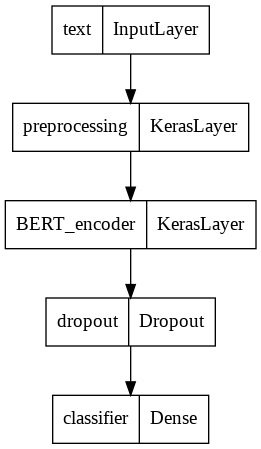

In [40]:
tf.keras.utils.plot_model(classifier_model)

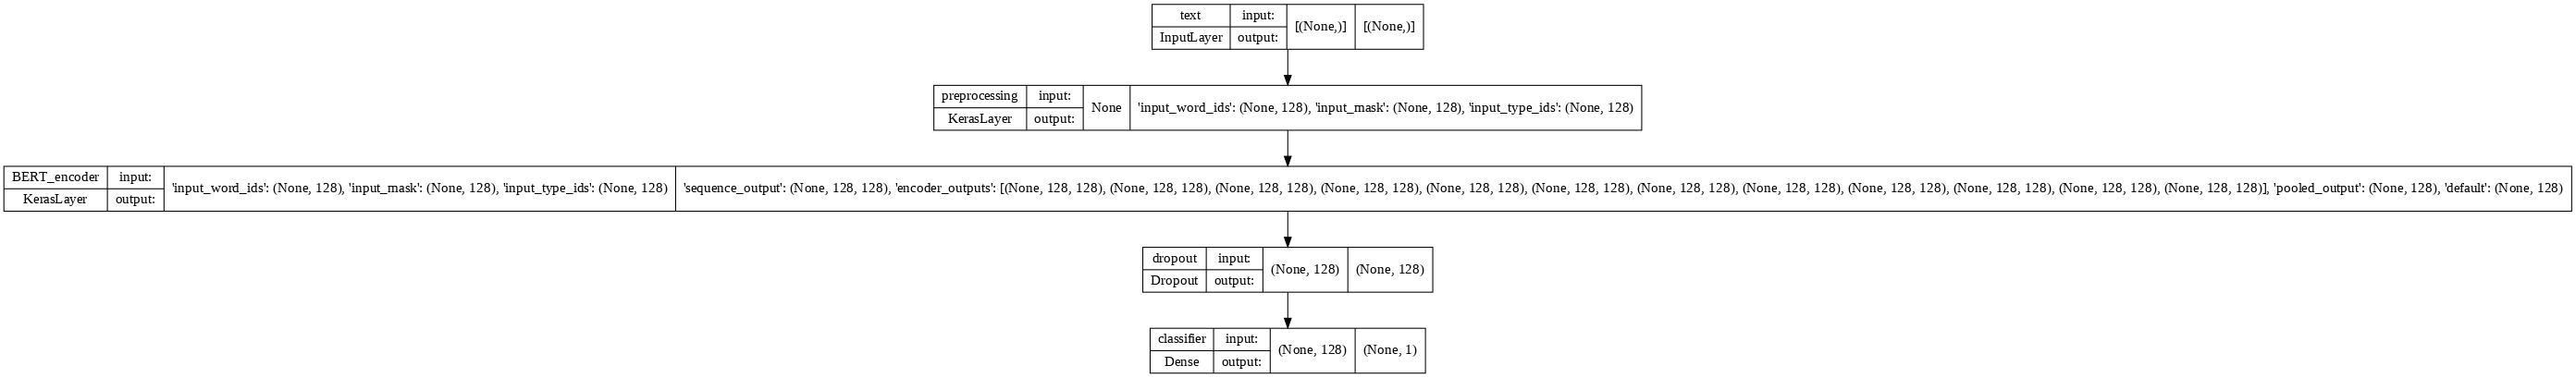

In [41]:
tf.keras.utils.plot_model(model=classifier_model, show_shapes=True, dpi=76, )

In [42]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

Por último, definimos la función de pérdida (entropía cruzada, para clasifiación binaria) y las métricas (escogemos AUC, precisión y cobertura).

In [43]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics =  [tf.keras.metrics.BinaryAccuracy()
            #tf.keras.metrics.PrecisionAtRecall(0.5),
            ,tf.keras.metrics.AUC()
            ,tf.keras.metrics.Precision()
            ,tf.keras.metrics.Recall()
            #,tfa.metrics.F1Score(num_classes=2)
            ]

---

<a name='training'></a>
# 4. ENTRENAMIENTO

Definimos los parámetros del entrenamiento (bajos epochs), un optimizador dinámico (proveniente de la referencia de apoyo), compilamos el modelo.

In [44]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
#optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

In [41]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Ejecución del entrenamiento

In [41]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_dataset,
                               validation_data=valid_dataset,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1
Epoch 1/10
548/548 [==============================] - 190s 299ms/step - loss: 0.4497 - binary_accuracy: 0.7978 - auc: 0.7852 - precision: 0.6540 - recall: 0.3492 - val_loss: 0.3582 - val_binary_accuracy: 0.8533 - val_auc: 0.8839 - val_precision: 0.7703 - val_recall: 0.5614
Epoch 2/10
548/548 [==============================] - 160s 292ms/step - loss: 0.3591 - binary_accuracy: 0.8437 - auc: 0.8791 - precision: 0.7091 - recall: 0.6008 - val_loss: 0.3369 - val_binary_accuracy: 0.8625 - val_auc: 0.8935 - val_precision: 0.7563 - val_recall: 0.6377
Epoch 3/10
548/548 [==============================] - 160s 291ms/step - loss: 0.3351 - binary_accuracy: 0.8529 - auc: 0.8970 - precision: 0.7280 - recall: 0.6263 - val_loss: 0.3467 - val_binary_accuracy: 0.8450 - val_auc: 0.8940 - val_precision: 0.6728 - val_recall: 0.7013
Epoch 4/10
548/548 [==============================] - 160s 292ms/step - loss: 0.3146 

### Gráficas del entrenamiento

dict_keys(['loss', 'binary_accuracy', 'auc', 'precision', 'recall', 'val_loss', 'val_binary_accuracy', 'val_auc', 'val_precision', 'val_recall'])


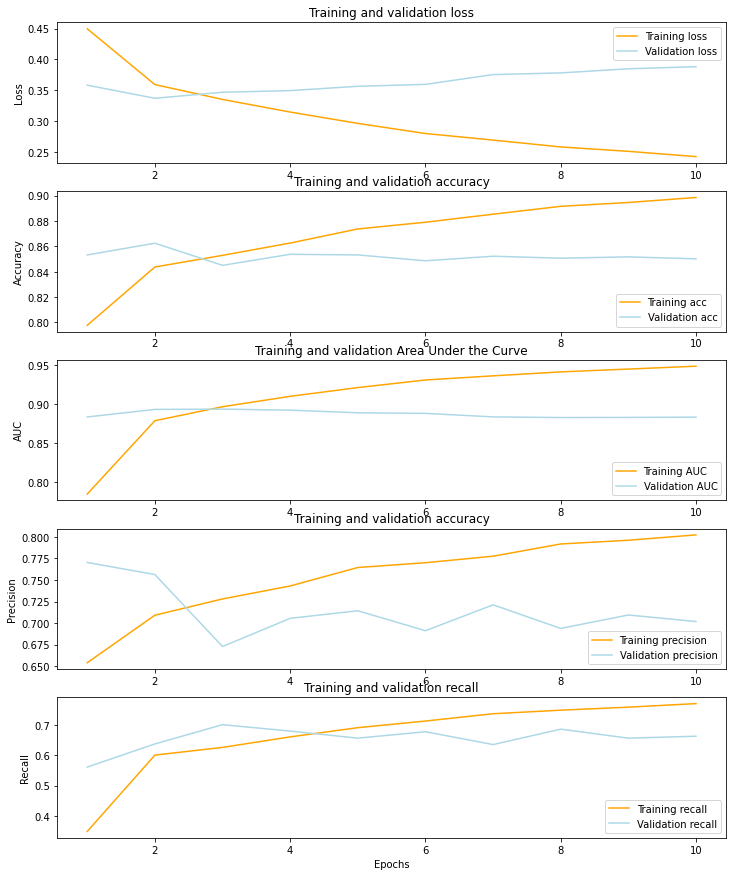

In [74]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

auc = history_dict['auc']
val_auc = history_dict['val_auc']
prec = history_dict['precision']
val_prec = history_dict['val_precision']
rec = history_dict['recall']
val_rec = history_dict['val_recall']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(12, 15))
fig.tight_layout()

plt.subplot(5, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'orange', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'lightblue', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(epochs, acc, 'orange', label='Training acc')
plt.plot(epochs, val_acc, 'lightblue', label='Validation acc')
plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(5, 1, 3)
plt.plot(epochs, auc, 'orange', label='Training AUC')
plt.plot(epochs, val_auc, 'lightblue', label='Validation AUC')
plt.title('Training and validation Area Under the Curve')
# plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(loc='lower right')

plt.subplot(5, 1, 4)
plt.plot(epochs, prec, 'orange', label='Training precision')
plt.plot(epochs, val_prec, 'lightblue', label='Validation precision')
plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(loc='lower right')

plt.subplot(5, 1, 5)
plt.plot(epochs, rec, 'orange', label='Training recall')
plt.plot(epochs, val_rec, 'lightblue', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend(loc='lower right')

Comentario: se puede apreciar que ocurre overfitting con rapidez 

## Backup y recuperación del modelo entrenado

In [45]:
dataset_name = 'webis'
saved_model_path = './{}_bert04'.format(dataset_name.replace('/', '_'))

In [76]:
classifier_model.save(saved_model_path, include_optimizer=False)

In [46]:
reloaded_model = tf.saved_model.load(saved_model_path)

---

<a name='evaluation'></a>
# 5. EVALUACIÓN

## Funciones auxiliares para la evaluación

#### Convertir a clase las predicciones probabilísticas

In [47]:
def convert_prediction_by_threshold(preds, threshold=0.5):
    preds_masked = tf.where(preds > threshold, tf.ones_like(preds), tf.zeros_like(preds)) 
    return preds_masked

#### Matriz de confusión

In [48]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn

In [49]:
def display_confusion_matrix_for_model_cm(cm):
    plt.figure(figsize = (12,10))
    ax = seaborn.heatmap(cm, cmap=plt.cm.Greens, 
                        annot=True, square=True,
                        xticklabels = ['no-clickbait (0)', 'clickbait (1)'], yticklabels = ['no-clickbait (0)', 'clickbait (1)'])
                        #xticklabels = CLASS_NAMES, yticklabels = CLASS_NAMES)
    ax.set_ylabel('Actual', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    
    fig_curr = plt.gcf()
    plt.show()


#### Curva **ROC**

In [50]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#plot_the_roc
from sklearn.metrics import roc_curve

def plot_roc(name, labels, predictions, **kwargs):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, color=colors[0])
    plt.plot([0, 100], [0, 100], label='random limit', linewidth=1, linestyle='--', color='black')
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,100.5])
    plt.ylim([-0.5,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.legend(loc='lower right')
    
    fig_curr = plt.gcf()
    plt.show()

#### Area bajo la curva **AUC**

In [51]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#plot_the_auprc
from sklearn.metrics import precision_recall_curve

def plot_prc(name, labels, predictions, **kwargs):
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    precision, recall, _ = precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, color=colors[1]) #**kwargs
    plt.plot([1, 0], [0, 1], label='random limit', linewidth=1, linestyle='--', color='black')
    
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')    
    plt.legend(loc='lower left')
      
    fig_curr = plt.gcf()
    plt.show()


## Evaluación del conjunto de test

Pasamos a evaluar la bondad del modelo sobre el conjunto de test facilitado para el ejercicio.

In [42]:
metrics = classifier_model.evaluate(test_dataset)

592/592 [==============================] - 111s 187ms/step - loss: 0.3537 - binary_accuracy: 0.8580 - auc: 0.9003 - precision: 0.7032 - recall: 0.6878


In [43]:
loss, accuracy, auc, precision, recall = metrics

In [48]:
print('Loss {:.2f}%'.format(loss*100))
print('Accuracy {:.2f}%'.format(accuracy*100))
print('AUC {:.2f}%'.format(auc*100))
print('Precision {:.2f}%'.format(precision*100))
print('Recall {:.2f}%'.format(recall*100))

Loss 35.37%
Accuracy 85.80%
AUC 90.03%
Precision 70.32%
Recall 68.78%


Las métricas de evaluación del conjunto de test muestran valores más cercanos a aquellos de validación que a los de training, lo que confirma el posible sobreajuste del modelo. Vamos a observar a través de tres herramientas los posibles ajustes y después nos centraremos en una muestra concreta.

In [105]:
test_samples_x = []
test_samples_y = []

for element in test_dataset.as_numpy_iterator(): 
    test_samples_x.append(element[0])
    test_samples_y.append(element[1])

# cada lista resultante se condensa en un único tensor
test_samples_x = tf.concat(test_samples_x, axis=0)
test_samples_y = tf.concat(test_samples_y, axis=0)

In [106]:
test_samples_x.shape

TensorShape([18913])

El siguiente código es una modificación ad-hoc. No pude ejecutar la predicción de todo el conjunto de test en GColab (no daba fallo, pero se "colgaba" la ejecución, sin avanzar.

Creé un bucle con lotes más pequeños que sí funcionó:

In [107]:
predictions_test = []
i = 0
jump = 200
while i < len(test_samples_x):
    print('From {} to {}'.format(i,i+jump), end=' ')
    predictions_test.append(reloaded_model(tf.constant(test_samples_x[i:i+jump])))
    i += jump

From 0 to 200 From 200 to 400 From 400 to 600 From 600 to 800 From 800 to 1000 From 1000 to 1200 From 1200 to 1400 From 1400 to 1600 From 1600 to 1800 From 1800 to 2000 From 2000 to 2200 From 2200 to 2400 From 2400 to 2600 From 2600 to 2800 From 2800 to 3000 From 3000 to 3200 From 3200 to 3400 From 3400 to 3600 From 3600 to 3800 From 3800 to 4000 From 4000 to 4200 From 4200 to 4400 From 4400 to 4600 From 4600 to 4800 From 4800 to 5000 From 5000 to 5200 From 5200 to 5400 From 5400 to 5600 From 5600 to 5800 From 5800 to 6000 From 6000 to 6200 From 6200 to 6400 From 6400 to 6600 From 6600 to 6800 From 6800 to 7000 From 7000 to 7200 From 7200 to 7400 From 7400 to 7600 From 7600 to 7800 From 7800 to 8000 From 8000 to 8200 From 8200 to 8400 From 8400 to 8600 From 8600 to 8800 From 8800 to 9000 From 9000 to 9200 From 9200 to 9400 From 9400 to 9600 From 9600 to 9800 From 9800 to 10000 From 10000 to 10200 From 10200 to 10400 From 10400 to 10600 From 10600 to 10800 From 10800 to 11000 From 11000

In [108]:
predictions_test = tf.concat(predictions_test, axis=0)
predictions_test.shape

TensorShape([18913, 1])

Matriz de confusión

In [109]:
predictions_test_masked = convert_prediction_by_threshold(predictions_test, 0.5)
cm_bert = confusion_matrix(tf.reshape(test_samples_y, -1), tf.reshape(predictions_test_masked, -1))

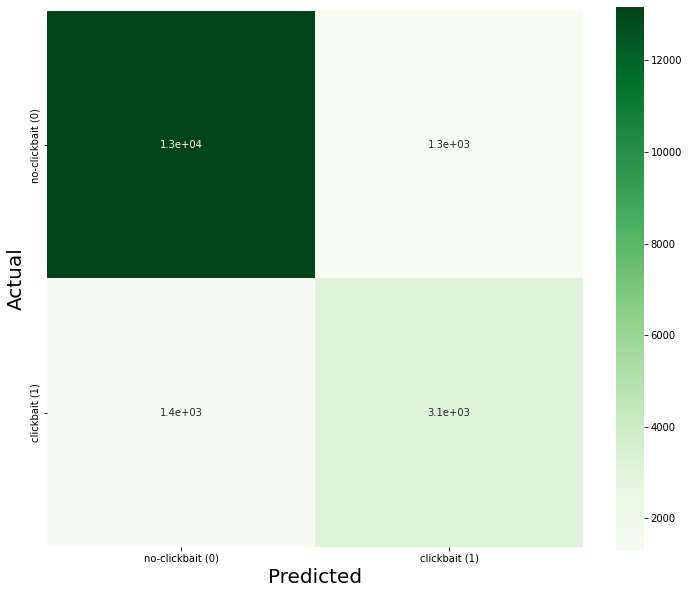

In [110]:
display_confusion_matrix_for_model_cm(cm_bert)

In [111]:
print(classification_report(tf.reshape(test_samples_y, -1), tf.reshape(predictions_test_masked, -1)))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91     14455
           1       0.70      0.69      0.70      4458

    accuracy                           0.86     18913
   macro avg       0.80      0.80      0.80     18913
weighted avg       0.86      0.86      0.86     18913



Curva ROC

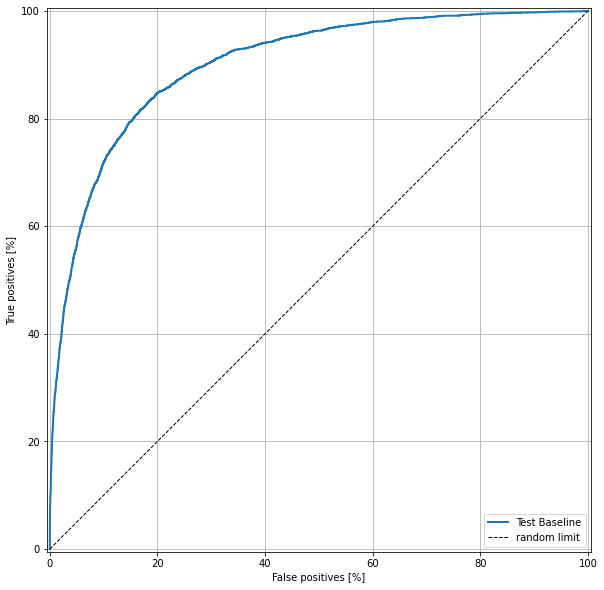

In [98]:
#mpl.rcParams['figure.figsize'] = (12, 10)
plt.figure(figsize=(15,10))
plot_roc("Test Baseline" 
         ,tf.reshape(test_samples_y, -1)       #las GT's, unravelled
         ,tf.reshape(predictions_test, -1) # las predicciones, unravelled
         #,color=colors[0]
         #, linestyle='--'
        )

Area bajo la curva **AUC**

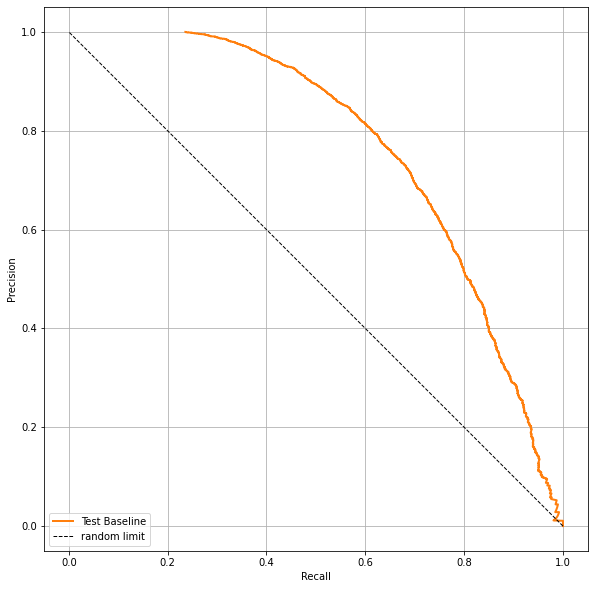

In [99]:
plt.figure(figsize=(15,10))
plot_prc("Test Baseline" 
         ,tf.reshape(test_samples_y, -1)       #las GT's, unravelled
         ,tf.reshape(predictions_test, -1) # las predicciones, unravelled
         #,color=colors[0], linestyle='--'
        )


No son resultados del todo malos, dado el contexto. El trade-off entre precisión y cobertura es bastante difuso. Se aprecia mayor dificultad del modelo para clasificar con acierto como CLICKBAIT, más que al determinar lo contrario (NO-CLICKBAIT).

## Evaluación en detalle de una muestra de test

Veamos rápidamente un puñado de ejemplos

In [102]:
def print_my_examples_test(inputs, results, gts):
  result_for_printing = \
    [f'ground truth: {gts[i]} ||| score: {results[i][0]:.6f} ||| input: {inputs[i]}' for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

test_samples_x = []
test_samples_y = []

for sample_x, sample_y in test_dataset.shuffle(42).take(1):
    pass

for i in range(len(sample_x)):
    test_samples_x.append(sample_x[i].numpy())
    test_samples_y.append(sample_y[i].numpy())

In [103]:
predictions_sample = reloaded_model(test_samples_x)

print('Results from the saved model:')
print_my_examples_test(test_samples_x, predictions_sample, test_samples_y)

Results from the saved model:
ground truth: 1 ||| score: 0.012631 ||| input: b'Heartbreaking Photos of Vets Being Neglected at VA Spark Outrage'
ground truth: 0 ||| score: 0.009565 ||| input: b'Sessions warns of an America with "marijuana sold at every corner grocery store"'
ground truth: 0 ||| score: 0.042035 ||| input: b'Fastest 40-yard dash?\n\nB/R experts make #NFLCombine predictions for each day'
ground truth: 0 ||| score: 0.021190 ||| input: b'UN accuses Germany of \xe2\x80\x98institutional racism and racist stereotyping\xe2\x80\x99'
ground truth: 0 ||| score: 0.002828 ||| input: b"TRUMP: The $54 billion increase in military spending will come from 'a revved up economy'"
ground truth: 0 ||| score: 0.007649 ||| input: b'#IanGrillot, 24, was struck in the hand and chest at the bar when #Puriton opened #fire'
ground truth: 0 ||| score: 0.140321 ||| input: b'RMIT/ABC Fact Check: Why is it needed and how will it work?'
ground truth: 0 ||| score: 0.007207 ||| input: b'When Trump speaks

En esta muestra, podemos observar los siguientes 3 fallos de predicción:

`ground truth: 1 ||| score: 0.012631 ||| input: b'Heartbreaking Photos of Vets Being Neglected at VA Spark Outrage'`

`ground truth: 1 ||| score: 0.369369 ||| input: b'Workers are flocking to these cities after better job oportunities and quality of life'`

`ground truth: 1 ||| score: 0.008062 ||| input: b'Second Oscar nominee banned from coming to the US to attend awards ceremony'`



Estos fallos corresponden todos a falsos negativos. No se han observado falsos positivos en esta pequeña muestra, lo que está en línea con lo mostrado en el resumen de la matriz de confusión (alta especificidad).

En mi opinión, solo hablando de esta pequeña muestra, los ejemplos primero y tercero pueden ser, intuitivamente, *fake-news*; en el segundo caso no me parece tan claro. 

## Conclusión


No me aventuro a sacar conclusiones de este corto análisis. Requeriría un mayor estudio de modelos y entrenamientos satisfactorios para poder ver una tendencia clara (ejemplo: ¿falta de capacidad de los modelos? ¿entrenamiento no del todo bien definido?, etcétera).

Creo que la aproximación es buena, dado lógicamente la robustez de la arquitectura BERT. Pero encontrar el modelo exacto más idóneo y el ajusto fino más correcto necesitaría prolongar el ejercicio.